# Motor encoding on neural manifolds in different brain regions
##### Project Contributors: Narotam Singh, Vaibhav, Rishika Mohanta, Prakriti Nayak

##### Done as part of [Neuromatch Academy](https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb) July 13-31 2020

In [1]:
#@title Import Modules
import numpy as np
from sklearn.linear_model import LinearRegression,SGDRegressor,RidgeCV
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score
import pandas as pd
from numpy.random import default_rng

In [2]:
#@title Helper functions
def sampler(data, N = 50, Train_N = 80, Test_N = 20, brain_region = None):  ## Samples for each Session
  rng = default_rng()
  trial_index = rng.choice(data['spks'].shape[1], size=100, replace=False)
  if brain_region:
    data_temp = data['spks'][data['brain_area']==brain_region,:,:]
  else:
    data_temp = data['spks']
  neuron_index = rng.choice(data_temp.shape[0], size=50, replace=False)
  train_trial_index = trial_index[0:Train_N]
  test_trial_index = trial_index[Train_N:-1 ]
  return neuron_index, train_trial_index, test_trial_index

def get_relevant_trial(data, neuron_idx, idx, start, end):
    motion = data["wheel"][0][idx]
    spikes = data["spks"][neuron_idx, idx,:]
    return spikes[:,start:end], motion[start:end]

def train_loop(data, neuron_index, train_trial_index, test_trial_index, d = 10, select_motion = True):  ## Samples for each Session
  start = int(data["stim_onset"]/data["bin_size"])
  model = RidgeCV()#SGDRegressor(penalty='l2')
  
  X_train,y_train = [],[]
  for idx in train_trial_index:
    end = int((data["stim_onset"]+data["gocue"][idx])/data["bin_size"])
    X_train_part, y_train_part = get_relevant_trial(data, neuron_index, idx, start, end)
    X_train_part = designmatrix(X_train_part,d = d)
    X_train.append(X_train_part)
    y_train.append(y_train_part)
  
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)  
  model.fit(X_train,y_train)
  y_pred = model.predict(X_train)
  r2_value_train = r2_score(y_train, y_pred)
  rvalue_train = linregress(y_train,y_pred).rvalue

  X_test,y_test = [],[]
  for idx in test_trial_index:
    end = int((data["stim_onset"]+data["gocue"][idx])/data["bin_size"])
    X_test_part, y_test_part = get_relevant_trial(data, neuron_index, idx, start, end)
    X_test_part = designmatrix(X_test_part,d = d)  
    X_test.append(X_test_part)
    y_test.append(y_test_part)
    
  X_test = np.concatenate(X_test)
  y_test = np.concatenate(y_test)  
  y_pred = model.predict(X_test)
  r2_value = r2_score(y_test, y_pred)
  rvalue = linregress(y_test,y_pred).rvalue

  return model, r2_value, rvalue

def designmatrix(X,d=20):
   #print(X.shape)
   padded_stim = np.column_stack((np.zeros((X.shape[0],d-1)),X))
   X_design = np.zeros((X.shape[1],d*X.shape[0]))
   for t in range(X.shape[1]):
     X_design[t] = padded_stim[:,t:t+d].flatten()
   return np.column_stack((np.ones(X.shape[1]),X_design))


##Data retreival and Loading

In [3]:
alldata = np.load('train.npz', allow_pickle=True)['arr_0']

In [4]:
for i in range(len(alldata)):
  dat = alldata[i]
  print(f"index {i}  brain areas {set(dat['brain_area'])} Neurons {dat['spks'].shape[0]}")

index 0  brain areas {'MOs'} Neurons 113
index 1  brain areas {'MOs', 'VPL'} Neurons 164
index 2  brain areas {'VPL', 'CP'} Neurons 165
index 3  brain areas {'MOs'} Neurons 112
index 4  brain areas {'VPL'} Neurons 73
index 5  brain areas {'CP', 'MOp'} Neurons 722
index 6  brain areas {'MD'} Neurons 126
index 7  brain areas {'MOs'} Neurons 186
index 8  brain areas {'VPM'} Neurons 162
index 9  brain areas {'VPM'} Neurons 60
index 10  brain areas {'SNr', 'CP'} Neurons 287
index 11  brain areas {'MOp', 'SSp'} Neurons 377
index 12  brain areas {'MOs'} Neurons 65
index 13  brain areas {'SCig'} Neurons 366
index 14  brain areas {'MOs', 'SCig'} Neurons 266
index 15  brain areas {'MOs', 'SCig'} Neurons 356
index 16  brain areas {'MOs'} Neurons 97
index 17  brain areas {'SCig'} Neurons 65
index 18  brain areas {'CP', 'MOp', 'SSp'} Neurons 750
index 19  brain areas {'MD', 'VPM'} Neurons 255
index 20  brain areas {'SNr', 'MOs'} Neurons 398
index 21  brain areas {'MOs', 'SCm'} Neurons 125
index 22 

In [53]:
from tqdm import tqdm 
result = []
#best_d_dict = {}
for i in tqdm(range(len(alldata))):
  dat = alldata[i]
  ba = set(dat['brain_area'])
  #ba_d = []
  for bb in ba:
    for _ in range(5):
      neuron_index, train_trial_index, test_trial_index = sampler(dat, brain_region = bb)
      best_d, best_r2 = -1, -np.inf
      samplingrange = np.arange(1, 24, 2)
      np.random.shuffle(samplingrange)
      for d in samplingrange:
        model, r2, corr_coeff = train_loop(dat, neuron_index, train_trial_index, test_trial_index, d)
        if r2 > best_r2 :
          best_d, best_r2 = d, corr_coeff
      
      model, r2, corr_coeff = train_loop(dat, neuron_index, train_trial_index, test_trial_index, best_d)
      result.append([ i, bb, best_d, [neuron_index], [train_trial_index], [test_trial_index], model, corr_coeff ,r2])
  #best_d_dict[i] = [ba_d]

df = pd.DataFrame(result)
df.columns = ["#Session_Number", "Brain_Areas", "Optimal_d", "#Neurons_Used","Train_index", "Test_index", "Model", "Correlation_Coefficient","R2_score"]

df.to_csv('result.csv', index=False)
df

100%|██████████████████████████████████████████████████████████████████| 27/27 [32:44<00:00, 72.75s/it]


,#Session_Number,Brain_Areas,Optimal_d,#Neurons_Used,Train_index,Test_index,Model,Correlation_Coefficient,R2_score
0,0,MOs,21,"[[4, 72, 7, 10, 25, 105, 31, 59, 63, 6, 48, 29...","[[65, 30, 6, 1, 108, 82, 24, 150, 47, 15, 71, ...","[[102, 64, 118, 116, 121, 69, 101, 85, 27, 128...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.522002,0.258339
1,0,MOs,17,"[[1, 66, 23, 64, 58, 96, 20, 22, 73, 48, 21, 5...","[[146, 44, 116, 149, 129, 53, 88, 167, 70, 58,...","[[38, 3, 103, 86, 2, 48, 37, 22, 67, 7, 55, 89...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.597453,0.352888
2,0,MOs,7,"[[110, 92, 68, 36, 71, 6, 20, 62, 95, 69, 31, ...","[[68, 48, 57, 19, 46, 22, 49, 169, 160, 85, 78...","[[41, 7, 95, 168, 143, 82, 28, 21, 118, 87, 81...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.445248,0.169227
3,0,MOs,17,"[[47, 39, 59, 68, 50, 92, 93, 34, 33, 82, 7, 6...","[[160, 65, 12, 24, 112, 135, 61, 83, 105, 15, ...","[[25, 5, 116, 169, 77, 107, 74, 72, 117, 88, 1...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.811248,0.652821
4,0,MOs,15,"[[38, 31, 36, 78, 21, 19, 70, 14, 97, 60, 49, ...","[[67, 133, 142, 93, 88, 149, 140, 119, 109, 61...","[[131, 154, 169, 50, 146, 91, 8, 104, 17, 100,...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.748888,0.515717
...,...,...,...,...,...,...,...,...,...
195,26,MOs,15,"[[23, 2, 32, 46, 48, 41, 43, 22, 17, 7, 30, 37...","[[219, 19, 8, 54, 242, 237, 248, 236, 169, 167...","[[194, 136, 82, 224, 51, 111, 9, 62, 175, 61, ...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.253831,0.033970
196,26,MOs,15,"[[24, 34, 21, 3, 40, 43, 20, 52, 22, 23, 32, 3...","[[260, 255, 22, 123, 234, 240, 181, 83, 81, 23...","[[11, 59, 105, 212, 48, 224, 19, 250, 27, 191,...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.327952,0.103576
197,26,MOs,15,"[[51, 50, 40, 25, 6, 12, 0, 42, 20, 1, 38, 37,...","[[66, 38, 13, 122, 176, 9, 184, 67, 185, 211, ...","[[83, 118, 120, 207, 191, 41, 95, 131, 140, 18...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.482105,0.214736
198,26,MOs,21,"[[17, 27, 34, 35, 47, 39, 0, 26, 10, 6, 49, 16...","[[30, 254, 198, 73, 250, 43, 270, 143, 136, 17...","[[31, 271, 188, 151, 234, 264, 165, 22, 153, 1...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.136780,-0.007284


In [54]:
import seaborn as sns

In [55]:
df.head()

,#Session_Number,Brain_Areas,Optimal_d,#Neurons_Used,Train_index,Test_index,Model,Correlation_Coefficient,R2_score
0,0,MOs,21,"[[4, 72, 7, 10, 25, 105, 31, 59, 63, 6, 48, 29...","[[65, 30, 6, 1, 108, 82, 24, 150, 47, 15, 71, ...","[[102, 64, 118, 116, 121, 69, 101, 85, 27, 128...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.522002,0.258339
1,0,MOs,17,"[[1, 66, 23, 64, 58, 96, 20, 22, 73, 48, 21, 5...","[[146, 44, 116, 149, 129, 53, 88, 167, 70, 58,...","[[38, 3, 103, 86, 2, 48, 37, 22, 67, 7, 55, 89...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.597453,0.352888
2,0,MOs,7,"[[110, 92, 68, 36, 71, 6, 20, 62, 95, 69, 31, ...","[[68, 48, 57, 19, 46, 22, 49, 169, 160, 85, 78...","[[41, 7, 95, 168, 143, 82, 28, 21, 118, 87, 81...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.445248,0.169227
3,0,MOs,17,"[[47, 39, 59, 68, 50, 92, 93, 34, 33, 82, 7, 6...","[[160, 65, 12, 24, 112, 135, 61, 83, 105, 15, ...","[[25, 5, 116, 169, 77, 107, 74, 72, 117, 88, 1...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.811248,0.652821
4,0,MOs,15,"[[38, 31, 36, 78, 21, 19, 70, 14, 97, 60, 49, ...","[[67, 133, 142, 93, 88, 149, 140, 119, 109, 61...","[[131, 154, 169, 50, 146, 91, 8, 104, 17, 100,...","RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...",0.748888,0.515717


(-1.0, 1.0)

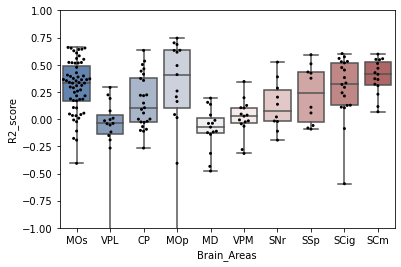

In [56]:
sns.boxplot(x='Brain_Areas',y='R2_score',data=df,whis=[0, 100], palette="vlag")
sns.swarmplot(x='Brain_Areas',y='R2_score',data=df, size=3, color="k", linewidth=0)
plt.ylim((-1,1))

(-1.0, 1.0)

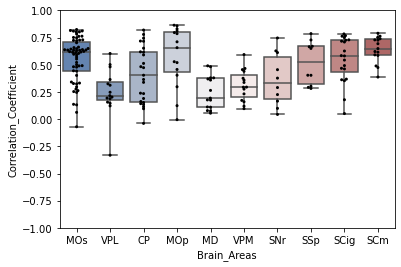

In [57]:
sns.boxplot(x='Brain_Areas',y='Correlation_Coefficient',data=df,whis=[0, 100], palette="vlag")
sns.swarmplot(x='Brain_Areas',y='Correlation_Coefficient',data=df, size=3, color="k", linewidth=0)
plt.ylim((-1,1))

<AxesSubplot:xlabel='Brain_Areas', ylabel='Optimal_d'>

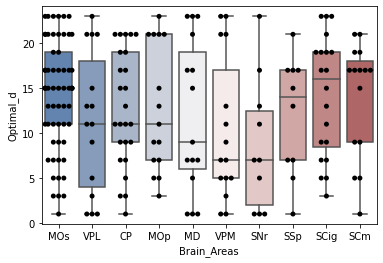

In [58]:
sns.boxplot(x='Brain_Areas',y='Optimal_d',data=df,whis=[0, 100], palette="vlag")
sns.swarmplot(x='Brain_Areas',y='Optimal_d',data=df, size=5, color="k", linewidth=0)

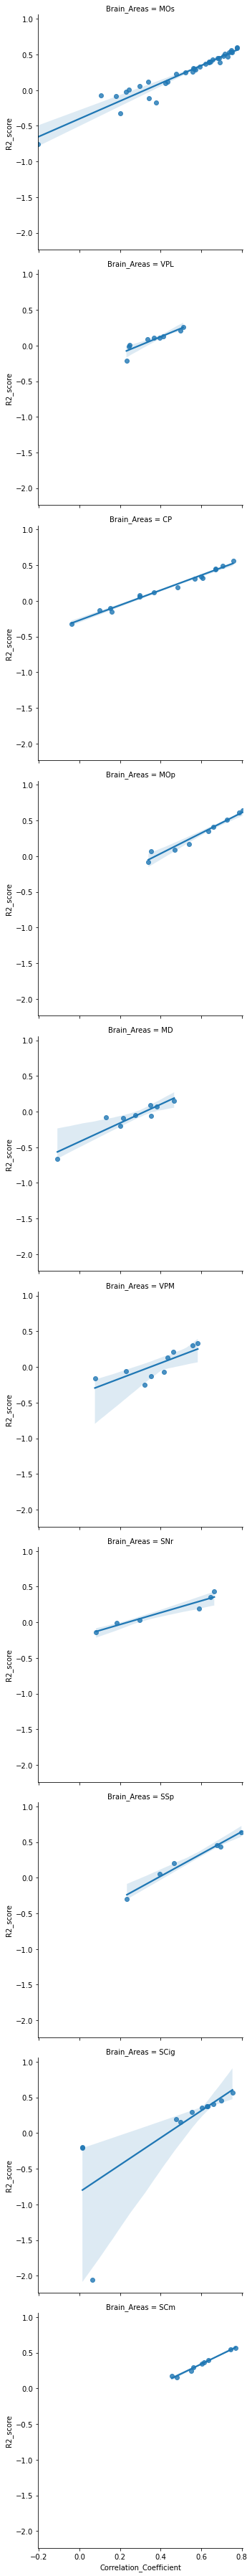

In [38]:
sns.lmplot('Correlation_Coefficient','R2_score',data=df,row='Brain_Areas')

(array([  0.,   0.,   0.,   0.,   0., 400.,   0.,   0.,   0.,   0.]),
 array([19.5, 19.6, 19.7, 19.8, 19.9, 20. , 20.1, 20.2, 20.3, 20.4, 20.5]),
 <BarContainer object of 10 artists>)

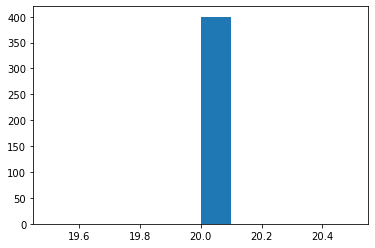

In [47]:
plt.hist(df.Optimal_d)

In [37]:
np.mean(df.Optimal_d)

13.375

In [83]:
pos = 0
kernel_space = df.Model[pos].coef_[1:]

In [84]:
KSX = np.array(np.split(kernel_space,50))

In [85]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [86]:
TSNEmodel = TSNE(n_components=2)
PCAmodel = PCA(n_components=3)

In [87]:
transformed_tsne = TSNEmodel.fit_transform(KSX)
transformed_pca = PCAmodel.fit_transform(KSX)

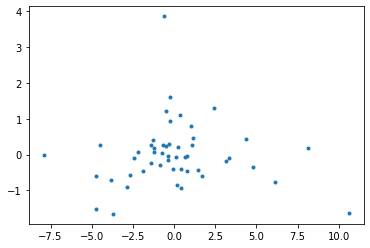

In [88]:
plt.plot(transformed_pca[:,0],transformed_pca[:,1],'.')

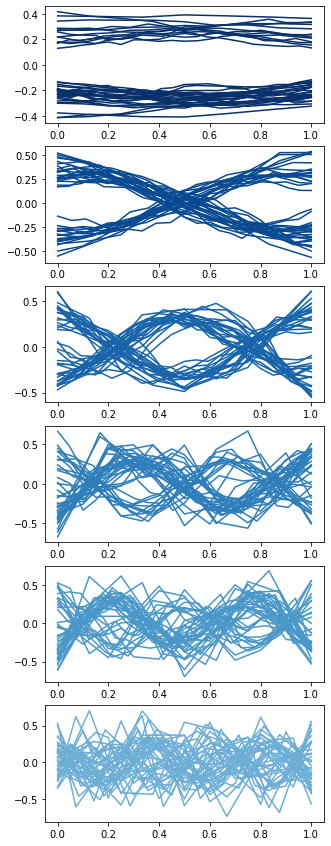

In [94]:
plt.figure(figsize=(5,15))
for i in range(0,6):
    plt.subplot(6,1,i+1)
    for pos in range(50):
        kernel_space = df.Model[pos].coef_[1:]
        KSX = np.array(np.split(kernel_space,50))
        if KSX.shape[1]<=5:
            continue
        PCAmodel = PCA()
        transformed_pca = PCAmodel.fit_transform(KSX)
        plt.plot(np.linspace(0,1,PCAmodel.components_[i].shape[0]),PCAmodel.components_[i],color=plt.cm.Blues_r(i/10),label=f'{i+1}')

In [69]:
df.Model[pos].coef_[1:].shape

(50,)